# Step 3: SDG

In [1]:
%pwd

'C:\\Users\\flore\\source\\repos\\master-thesis-vt23\\notebooks'

In [2]:
# necessary imports for the section
from sdv.single_table import CTGANSynthesizer as CTGAN
from sdv.metadata import SingleTableMetadata

import pickle
import pandas as pd 
import os 
import sys

sys.path.append('../src')
from utils import (getPicklesFromDir, 
                   getExperimentConfig, 
                   extract_loss_info_from_stdout, 
                   create_loss_plot)

from mlflow_manager import MLFlowManager

# Get global experiment settings
config = getExperimentConfig()
# Get folders
folders = config['folders']
# Get dataset specific settings
dataset_settings = getPicklesFromDir(folders['settings_dir'])

In [3]:
from io import StringIO


def capture_stdout(func):
    def wrapper(*args, **kwargs):
        # Save the original stdout
        original_stdout = sys.stdout

        # Create a new StringIO object to temporarily redirect stdout
        sys.stdout = StringIO()

        # Call the original function and get its output
        func_output = func(*args, **kwargs)

        # Retrieve the captured stdout
        captured_stdout = sys.stdout.getvalue()

        # Restore the original stdout
        sys.stdout = original_stdout

        # Return both the function output and the captured stdout
        return func_output, captured_stdout

    return wrapper

@capture_stdout
def train_sdg_model(model, data, sdg_name):
    print("#START#")
    print(sdg_name)
    model.fit(data)
    print("#END#")
    
    return model

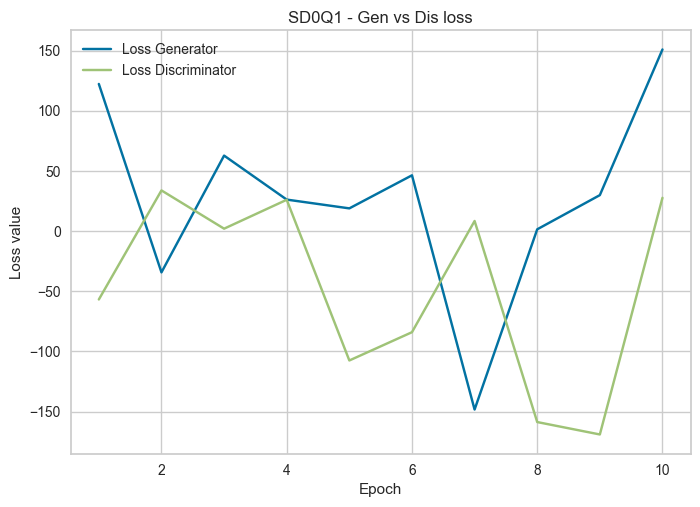

In [4]:
# Specify datasets by Id, if None, all is run
run_dataset = config['run_dataset']

# get settings
quality_params = config['ctgan_param']['quality_params']
sd_size_factor = config['ctgan_param']['sd_size_factor']
num_SD = config['ctgan_param']['num_sd']


# run SDG generation
# for each dataset specific settings
for s_index, settings in enumerate(dataset_settings):
    
    if run_dataset is not None and settings['meta']['id'] not in run_dataset:
        continue
    
    metadata = SingleTableMetadata().load_from_json(settings['meta']['meta_filepath'])
    # Init experiment logging
    experiment_name = f"{settings['meta']['id']}-SDG-models"
    mlflow = MLFlowManager(experiment_name)
    
    # load original dataset
    original_data = pd.read_csv(folders['real_dir'] + settings['meta']['filename'])  
    
    # get the size to generate the synthetic data
    original_data_size = len(original_data)
    sd_size = original_data_size * sd_size_factor
    
    logg_tags = {'Source': settings['meta']['id']}
    
    # loop through the different quality parameters for the SDG
    for quality in quality_params:
        
        logg_tags['Quality'] = quality
        
        sdg_name = f"S{settings['meta']['id']}{quality}"
        log_run = mlflow.start_run(sdg_name, tags=logg_tags)
        mlflow.log_params(quality_params[quality])
        
        # creates model with sdg_param and quality_param as parameters
        
        #print("#START#")   # for capturing loss info
        model = CTGAN(metadata=metadata, **quality_params[quality])
        
        #print(sdg_name)   # for capturing loss info
        #model.fit(original_data)
        
        model, stdout_loss = train_sdg_model(model, original_data, sdg_name)
        # extract loss, create loss plot and save it
        loss_dict = extract_loss_info_from_stdout(stdout_loss)
        fig = create_loss_plot(sdg_name, loss_dict[sdg_name])
        #save fig
        fig_name = f"{sdg_name}_loss_plot.png"
        fig.savefig(fig_name)
        mlflow.log_artifact(fig_name)
        os.remove(fig_name)
        #save data
        loss_df_name = f"{sdg_name}_loss.csv"
        loss_dict[sdg_name].to_csv(loss_df_name, index=False)
        mlflow.log_artifact(loss_df_name)
        os.remove(loss_df_name)
        
        
        # saves the SDG model using cloudpickle
        model_file = f"{sdg_name}.pkl"
        model.save(model_file) 
        mlflow.log_artifact(model_file)
        
        if os.path.isfile(model_file):
            os.remove(model_file)
        
        #print("#END#")   # for capturing loss info
        mlflow.end_run()
        
        # create num_SD SDGs and synthetic datasets for validating results
        for itr in range(num_SD):
            
            # creates Synthetic dataset name, using datset id, quality key, and itr number 
            # e.g. SD1Q1_2 means SDG trained on datset D1 with quality Q1 and copy num 2
            SD_name = f"S{settings['meta']['id']}{quality}_{str(itr)}"
            
            # relative file path for the synthetic dataset
            sd_path = f"{folders['sd_dir']}{SD_name}.csv"
            
            # generate synthetic data
            synthetic_data = model.sample(num_rows=sd_size)
            
            # save the synthetic dataset
            synthetic_data.to_csv(sd_path, index=False)
            
    mlflow.end_run()

In [5]:
""" The Loss values captured from the cell above's standard output will 
be used to create the generator vs discriminator loss plots.
"""

"""
#Deprecated
loss_values = extract_loss_info_from_stdout(stdout_loss.stdout)

if (loss_values not None):
    # Combine the loss values and save them
    combined_loss_df = pd.concat(loss_values.values(), keys=loss_values.keys(), axis=0, ignore_index=False)
    combined_loss_df = combined_loss_df.reset_index().rename(columns={'level_0': 'SDG'})
    combined_loss_df.to_csv(f"{folders['data_dir']}combined_sdg_loss.csv", index=False)

    for sdg_id in loss_values:
        fig = create_loss_plot(sdg_id, loss_values[sdg_id])
        # Save the plot to correct mlflow log
        run=mlflow.load_run_by_name(sdg_id)
        path=run.info.artifact_uri.replace("file:///", "")
        #save plot
        fig.savefig(f"{path}/{sdg_id}_loss_plot.png")
        #save data
        loss_values[sdg_id].to_csv(f"{path}/{sdg_id}.csv", index=False)

"""

'\n#Deprecated\nloss_values = extract_loss_info_from_stdout(stdout_loss.stdout)\n\nif (loss_values not None):\n    # Combine the loss values and save them\n    combined_loss_df = pd.concat(loss_values.values(), keys=loss_values.keys(), axis=0, ignore_index=False)\n    combined_loss_df = combined_loss_df.reset_index().rename(columns={\'level_0\': \'SDG\'})\n    combined_loss_df.to_csv(f"{folders[\'data_dir\']}combined_sdg_loss.csv", index=False)\n\n    for sdg_id in loss_values:\n        fig = create_loss_plot(sdg_id, loss_values[sdg_id])\n        # Save the plot to correct mlflow log\n        run=mlflow.load_run_by_name(sdg_id)\n        path=run.info.artifact_uri.replace("file:///", "")\n        #save plot\n        fig.savefig(f"{path}/{sdg_id}_loss_plot.png")\n        #save data\n        loss_values[sdg_id].to_csv(f"{path}/{sdg_id}.csv", index=False)\n\n'

---